In [1]:
import tensorflow as tf
import numpy as np
import math
import json
import sys
import os
import random
from tqdm import tqdm
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import os
import json

from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt

BASE_DIR = os.path.dirname(os.path.abspath('__file__'))
sys.path.append(BASE_DIR)
sys.path.append(os.path.join(BASE_DIR, './utils'))

with open("/Users/davidxu/datasets/PartAnnotation/metadata.json") as json_file:
    metadata = json.load(json_file)


points_dir = "/Users/davidxu/datasets/PartAnnotation/{}/points".format(
    metadata["Airplane"]["directory"]
)
labels_dir = "/Users/davidxu/datasets/PartAnnotation/{}/points_label".format(
    metadata["Airplane"]["directory"]
)
LABELS = metadata["Airplane"]["lables"]
COLORS = metadata["Airplane"]["colors"]


In [4]:
VAL_SPLIT = 0.2
NUM_SAMPLE_POINTS = 1024
BATCH_SIZE = 32
EPOCHS = 60
INITIAL_LR = 1e-3

In [5]:
point_clouds, test_point_clouds = [], []
point_cloud_labels, all_labels = [], []

points_files = glob(os.path.join(points_dir, "*.pts"))
for point_file in tqdm(points_files):
    point_cloud = np.loadtxt(point_file)
    if point_cloud.shape[0] < NUM_SAMPLE_POINTS:
        continue

    # Get the file-id of the current point cloud for parsing its
    # labels.
    file_id = point_file.split("/")[-1].split(".")[0]
    label_data, num_labels = {}, 0
    for label in LABELS:
        label_file = os.path.join(labels_dir, label, file_id + ".seg")
        if os.path.exists(label_file):
            label_data[label] = np.loadtxt(label_file).astype("float32")
            num_labels = len(label_data[label])

    # Point clouds having labels will be our training samples.
    try:
        label_map = ["none"] * num_labels
        for label in LABELS:
            for i, data in enumerate(label_data[label]):
                label_map[i] = label if data == 1 else label_map[i]
        label_data = [
            LABELS.index(label) if label != "none" else len(LABELS)
            for label in label_map
        ]
        # Apply one-hot encoding to the dense label representation.
        label_data = tf.keras.utils.to_categorical(label_data, num_classes=len(LABELS) + 1)

        point_clouds.append(point_cloud)
        point_cloud_labels.append(label_data)
        all_labels.append(label_map)
    except KeyError:
        test_point_clouds.append(point_cloud)


100%|███████████████████████████████████████| 4045/4045 [04:42<00:00, 14.33it/s]


In [17]:
print(np.array(point_clouds).shape)
print(np.array(point_cloud_labels).shape)

(3694, 1024, 3)
(3694, 1024, 5)


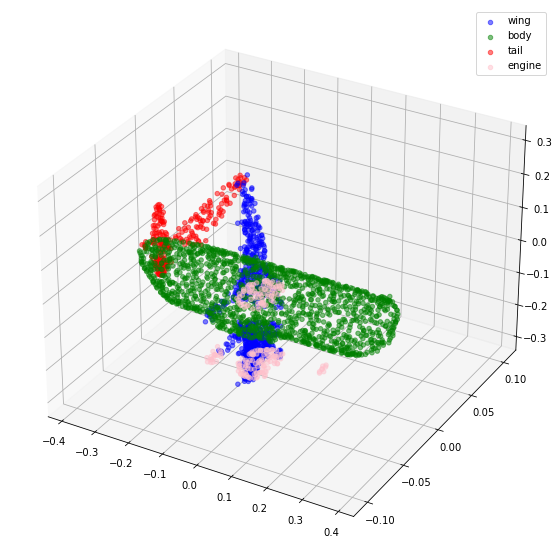

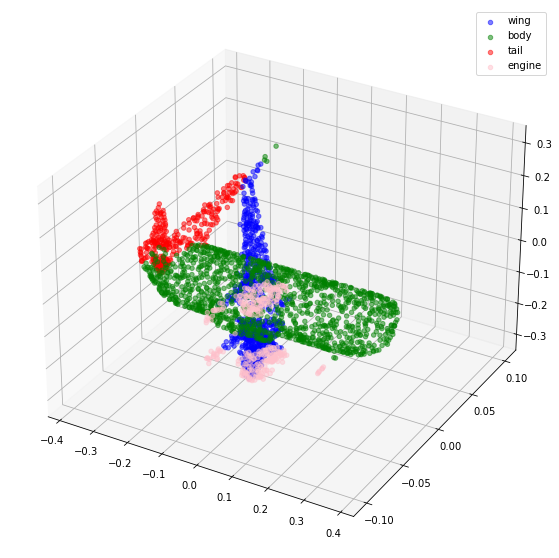

In [4]:
def visualize_data(point_cloud, labels):
    df = pd.DataFrame(
        data={
            "x": point_cloud[:, 0],
            "y": point_cloud[:, 1],
            "z": point_cloud[:, 2],
            "label": labels,
        }
    )
    fig = plt.figure(figsize=(15, 10))
    ax = plt.axes(projection="3d")
    for index, label in enumerate(LABELS):
        c_df = df[df["label"] == label]
        try:
            ax.scatter(
                c_df["x"], c_df["y"], c_df["z"], label=label, alpha=0.5, c=COLORS[index]
            )
        except IndexError:
            pass
    ax.legend()
    plt.show()


visualize_data(point_clouds[0], all_labels[0])
visualize_data(point_clouds[300], all_labels[300])

In [6]:
for index in tqdm(range(len(point_clouds))):
    current_point_cloud = point_clouds[index]
    current_label_cloud = point_cloud_labels[index]
    current_labels = all_labels[index]
    num_points = len(current_point_cloud)
    # Randomly sampling respective indices.
    sampled_indices = random.sample(list(range(num_points)), NUM_SAMPLE_POINTS)
    # Sampling points corresponding to sampled indices.
    sampled_point_cloud = np.array([current_point_cloud[i] for i in sampled_indices])
    # Sampling corresponding one-hot encoded labels.
    sampled_label_cloud = np.array([current_label_cloud[i] for i in sampled_indices])
    # Sampling corresponding labels for visualization.
    sampled_labels = np.array([current_labels[i] for i in sampled_indices])
    # Normalizing sampled point cloud.
    norm_point_cloud = sampled_point_cloud - np.mean(sampled_point_cloud, axis=0)
    norm_point_cloud /= np.max(np.linalg.norm(norm_point_cloud, axis=1))
    point_clouds[index] = norm_point_cloud
    point_cloud_labels[index] = sampled_label_cloud
    all_labels[index] = sampled_labels

100%|██████████████████████████████████████| 3694/3694 [00:08<00:00, 435.02it/s]


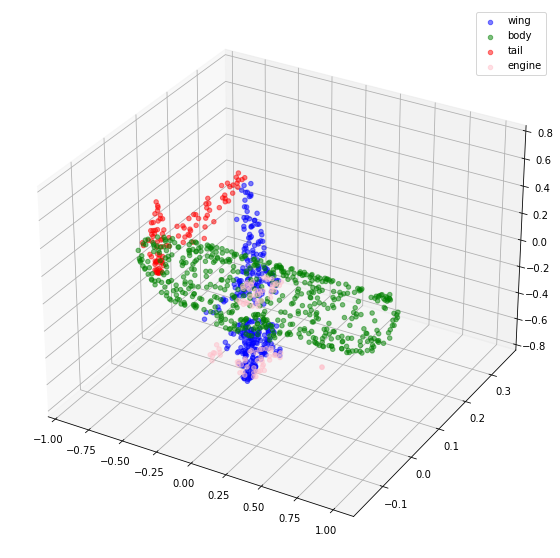

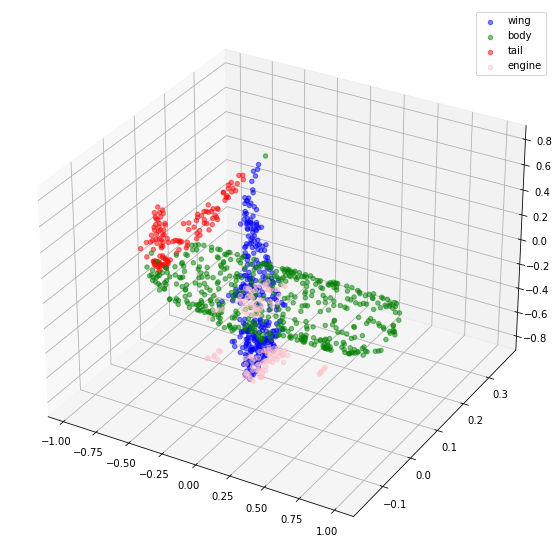

In [24]:
visualize_data(point_clouds[0], all_labels[0])
visualize_data(point_clouds[300], all_labels[300])

In [7]:
def load_data(point_cloud_batch, label_cloud_batch):
    point_cloud_batch.set_shape([NUM_SAMPLE_POINTS, 3])
    label_cloud_batch.set_shape([NUM_SAMPLE_POINTS, len(LABELS) + 1])
    return point_cloud_batch, label_cloud_batch


def augment(point_cloud_batch, label_cloud_batch):
    noise = tf.random.uniform(
        tf.shape(label_cloud_batch), -0.005, 0.005, dtype=tf.float64
    )
    point_cloud_batch += noise[:, :, :3]
    return point_cloud_batch, label_cloud_batch


def generate_dataset(point_clouds, label_clouds, is_training=True):
    # from_tensor_slices return an iterative object
    # it is a slice of the input
    dataset = tf.data.Dataset.from_tensor_slices((point_clouds, label_clouds))
    print(dataset)
    # take batch
    dataset = dataset.shuffle(BATCH_SIZE * 100) if is_training else dataset
    print(dataset)
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    print(dataset)
    # also changed to an iterative object
    dataset = dataset.batch(batch_size=BATCH_SIZE)
    print(dataset)
    dataset = (
        dataset.map(augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        if is_training
        else dataset
    )
    print(dataset)
    return dataset


split_index = int(len(point_clouds) * (1 - VAL_SPLIT))
train_point_clouds = point_clouds[:split_index]
print(np.array(train_point_clouds).shape)
train_label_cloud = point_cloud_labels[:split_index]
total_training_examples = len(train_point_clouds)

val_point_clouds = point_clouds[split_index:]
val_label_cloud = point_cloud_labels[split_index:]

print("Num train point clouds:", len(train_point_clouds))
print("Num train point cloud labels:", len(train_label_cloud))
print("Num val point clouds:", len(val_point_clouds))
print("Num val point cloud labels:", len(val_label_cloud))

train_dataset = generate_dataset(train_point_clouds, train_label_cloud)
val_dataset = generate_dataset(val_point_clouds, val_label_cloud, is_training=False)

print("Train Dataset:", train_dataset)
print("Validation Dataset:", val_dataset)

2022-02-21 01:40:08.363481: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-21 01:40:08.363837: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


(2955, 1024, 3)
Num train point clouds: 2955
Num train point cloud labels: 2955
Num val point clouds: 739
Num val point cloud labels: 739
<TensorSliceDataset shapes: ((1024, 3), (1024, 5)), types: (tf.float64, tf.float32)>
<ShuffleDataset shapes: ((1024, 3), (1024, 5)), types: (tf.float64, tf.float32)>
<ParallelMapDataset shapes: ((1024, 3), (1024, 5)), types: (tf.float64, tf.float32)>
<BatchDataset shapes: ((None, 1024, 3), (None, 1024, 5)), types: (tf.float64, tf.float32)>
<ParallelMapDataset shapes: ((None, 1024, 3), (None, 1024, 5)), types: (tf.float64, tf.float32)>
<TensorSliceDataset shapes: ((1024, 3), (1024, 5)), types: (tf.float64, tf.float32)>
<TensorSliceDataset shapes: ((1024, 3), (1024, 5)), types: (tf.float64, tf.float32)>
<ParallelMapDataset shapes: ((1024, 3), (1024, 5)), types: (tf.float64, tf.float32)>
<BatchDataset shapes: ((None, 1024, 3), (None, 1024, 5)), types: (tf.float64, tf.float32)>
<BatchDataset shapes: ((None, 1024, 3), (None, 1024, 5)), types: (tf.float64,

In [34]:
def conv_block(x: tf.Tensor, filters: int, name: str) -> tf.Tensor:
    x = layers.Conv1D(filters, kernel_size=1, padding="valid", name=f"{name}_conv")(x)
    x = layers.BatchNormalization(momentum=0.0, name=f"{name}_batch_norm")(x)
    return layers.Activation("relu", name=f"{name}_relu")(x)


def mlp_block(x: tf.Tensor, filters: int, name: str) -> tf.Tensor:
    x = layers.Dense(filters, name=f"{name}_dense")(x)
    x = layers.BatchNormalization(momentum=0.0, name=f"{name}_batch_norm")(x)
    return layers.Activation("relu", name=f"{name}_relu")(x)

class OrthogonalRegularizer(keras.regularizers.Regularizer):
    """Reference: https://keras.io/examples/vision/pointnet/#build-a-model"""

    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.identity = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.identity))

def transformation_net(inputs: tf.Tensor, num_features: int, name: str) -> tf.Tensor:
    """
    Reference: https://keras.io/examples/vision/pointnet/#build-a-model.

    The `filters` values come from the original paper:
    https://arxiv.org/abs/1612.00593.
    """
    x = conv_block(inputs, filters=64, name=f"{name}_1")
    x = conv_block(x, filters=128, name=f"{name}_2")
    x = conv_block(x, filters=1024, name=f"{name}_3")
    x = layers.GlobalMaxPooling1D()(x)
    x = mlp_block(x, filters=512, name=f"{name}_1_1")
    x = mlp_block(x, filters=256, name=f"{name}_2_1")
    return layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=keras.initializers.Constant(np.eye(num_features).flatten()),
        activity_regularizer=OrthogonalRegularizer(num_features),
        name=f"{name}_final",
    )(x)


def transformation_block(inputs: tf.Tensor, num_features: int, name: str) -> tf.Tensor:
    transformed_features = transformation_net(inputs, num_features, name=name)
    transformed_features = layers.Reshape((num_features, num_features))(
        transformed_features
    )
    return layers.Dot(axes=(2, 1), name=f"{name}_mm")([inputs, transformed_features])

def get_shape_segmentation_model(num_points: int, num_classes: int) -> keras.Model:
    input_points = keras.Input(shape=(None, 3))

    # PointNet Classification Network.
    transformed_inputs = transformation_block(
        input_points, num_features=3, name="input_transformation_block"
    )
    features_64 = conv_block(transformed_inputs, filters=64, name="features_64")
    features_128_1 = conv_block(features_64, filters=128, name="features_128_1")
    features_128_2 = conv_block(features_128_1, filters=128, name="features_128_2")
    transformed_features = transformation_block(
        features_128_2, num_features=128, name="transformed_features"
    )
    features_512 = conv_block(transformed_features, filters=512, name="features_512")
    features_2048 = conv_block(features_512, filters=2048, name="pre_maxpool_block")
    global_features = layers.MaxPool1D(pool_size=num_points, name="global_features")(
        features_2048
    )
    global_features = tf.tile(global_features, [1, num_points, 1])

    # Segmentation head.
    segmentation_input = layers.Concatenate(name="segmentation_input")(
        [
            features_64,
            features_128_1,
            features_128_2,
            transformed_features,
            features_512,
            global_features,
        ]
    )
    segmentation_features = conv_block(
        segmentation_input, filters=128, name="segmentation_features"
    )
    outputs = layers.Conv1D(
        num_classes, kernel_size=1, activation="softmax", name="segmentation_head"
    )(segmentation_features)
    return keras.Model(input_points, outputs)

In [14]:
x, y = next(iter(train_dataset))

num_points = x.shape[1]
num_classes = y.shape[-1]

segmentation_model = get_shape_segmentation_model(num_points, num_classes)
segmentation_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, None, 3)]    0                                            
__________________________________________________________________________________________________
input_transformation_block_1_co (None, None, 64)     256         input_6[0][0]                    
__________________________________________________________________________________________________
input_transformation_block_1_ba (None, None, 64)     256         input_transformation_block_1_conv
__________________________________________________________________________________________________
input_transformation_block_1_re (None, None, 64)     0           input_transformation_block_1_batc
____________________________________________________________________________________________

In [13]:
from utils.pointnet_seg import get_shape_segmentation_model

x, y = next(iter(train_dataset))

num_points = x.shape[1]
num_classes = y.shape[-1]

segmentation_model = get_shape_segmentation_model(num_points, num_classes)
segmentation_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, None, 3)]    0                                            
__________________________________________________________________________________________________
input_transformation_block_1_co (None, None, 64)     256         input_5[0][0]                    
__________________________________________________________________________________________________
input_transformation_block_1_ba (None, None, 64)     256         input_transformation_block_1_conv
__________________________________________________________________________________________________
input_transformation_block_1_re (None, None, 64)     0           input_transformation_block_1_batc
____________________________________________________________________________________________

Total training steps: 5520.


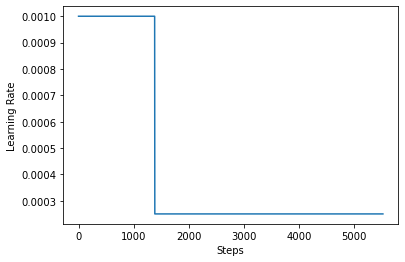

In [15]:
training_step_size = total_training_examples // BATCH_SIZE
total_training_steps = training_step_size * EPOCHS
print(f"Total training steps: {total_training_steps}.")

lr_schedule = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[training_step_size * 15, training_step_size * 15],
    values=[INITIAL_LR, INITIAL_LR * 0.5, INITIAL_LR * 0.25],
)

steps = tf.range(total_training_steps, dtype=tf.int32)
lrs = [lr_schedule(step) for step in steps]

plt.plot(lrs)
plt.xlabel("Steps")
plt.ylabel("Learning Rate")
plt.show()

In [ ]:
def run_experiment(epochs):

    segmentation_model = get_shape_segmentation_model(num_points, num_classes)
    segmentation_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=["accuracy"],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
    )

    history = segmentation_model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs,
        callbacks=[checkpoint_callback],
    )

    segmentation_model.load_weights(checkpoint_filepath)
    return segmentation_model, history


segmentation_model, history = run_experiment(epochs=EPOCHS)

Epoch 1/60
     93/Unknown - 1030s 11s/step - loss: 5.3797 - accuracy: 0.7222

2022-02-21 02:27:51.269198: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 [==============================] - 1108s 12s/step - loss: 5.3797 - accuracy: 0.7222 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/60
92/93 [============================>.] - ETA: 10s - loss: 4.7295 - accuracy: 0.8153

2022-02-21 02:45:46.692853: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 [==============================] - 1073s 12s/step - loss: 4.7294 - accuracy: 0.8151 - val_loss: 9.0832 - val_accuracy: 0.7596
Epoch 3/60
92/93 [============================>.] - ETA: 10s - loss: 4.7196 - accuracy: 0.8161

2022-02-21 03:03:39.731039: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 [==============================] - 1073s 12s/step - loss: 4.7195 - accuracy: 0.8162 - val_loss: 4.4947 - val_accuracy: 0.8343
Epoch 4/60
92/93 [============================>.] - ETA: 10s - loss: 4.6506 - accuracy: 0.8306

2022-02-21 03:21:33.824339: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 [==============================] - 1074s 12s/step - loss: 4.6504 - accuracy: 0.8307 - val_loss: 5.0223 - val_accuracy: 0.8099
Epoch 5/60
92/93 [============================>.] - ETA: 10s - loss: 27.8355 - accuracy: 0.7690

2022-02-21 03:39:25.563103: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 [==============================] - 1073s 12s/step - loss: 27.8974 - accuracy: 0.7684 - val_loss: 324737758.7841 - val_accuracy: 0.5976
Epoch 6/60
92/93 [============================>.] - ETA: 10s - loss: 63.0515 - accuracy: 0.7474

2022-02-21 03:57:18.743802: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 [==============================] - 1072s 12s/step - loss: 63.0491 - accuracy: 0.7475 - val_loss: 68.8836 - val_accuracy: 0.7336
Epoch 7/60
92/93 [============================>.] - ETA: 10s - loss: 7.4838 - accuracy: 0.7777

2022-02-21 04:15:11.697543: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 [==============================] - 1073s 12s/step - loss: 7.4837 - accuracy: 0.7776 - val_loss: 7.8939 - val_accuracy: 0.7764
Epoch 8/60
92/93 [============================>.] - ETA: 10s - loss: 6.0492 - accuracy: 0.7887

2022-02-21 04:33:05.457161: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 [==============================] - 1074s 12s/step - loss: 6.0490 - accuracy: 0.7888 - val_loss: 5.3085 - val_accuracy: 0.7919
Epoch 9/60
92/93 [============================>.] - ETA: 10s - loss: 5.4988 - accuracy: 0.7925

2022-02-21 04:50:57.005189: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 [==============================] - 1071s 12s/step - loss: 5.4987 - accuracy: 0.7926 - val_loss: 5.2914 - val_accuracy: 0.7756
Epoch 10/60
92/93 [============================>.] - ETA: 10s - loss: 5.2330 - accuracy: 0.7955

2022-02-21 05:08:47.644522: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 [==============================] - 1071s 12s/step - loss: 5.2329 - accuracy: 0.7951 - val_loss: 5.9303 - val_accuracy: 0.7564
Epoch 11/60
92/93 [============================>.] - ETA: 10s - loss: 5.0674 - accuracy: 0.7993

2022-02-21 05:26:38.350254: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 [==============================] - 1070s 12s/step - loss: 5.0672 - accuracy: 0.7993 - val_loss: 6.6031 - val_accuracy: 0.7930
Epoch 12/60
92/93 [============================>.] - ETA: 10s - loss: 4.9690 - accuracy: 0.8040

2022-02-21 05:44:31.128148: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 [==============================] - 1073s 12s/step - loss: 4.9689 - accuracy: 0.8038 - val_loss: 6.4262 - val_accuracy: 0.7793
Epoch 13/60
92/93 [============================>.] - ETA: 10s - loss: 4.8826 - accuracy: 0.8065

2022-02-21 06:02:25.018930: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 [==============================] - 1074s 12s/step - loss: 4.8825 - accuracy: 0.8064 - val_loss: 4.9258 - val_accuracy: 0.7858
Epoch 14/60
92/93 [============================>.] - ETA: 10s - loss: 4.8491 - accuracy: 0.8097

2022-02-21 06:20:17.114067: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 [==============================] - 1072s 12s/step - loss: 4.8490 - accuracy: 0.8095 - val_loss: 4.9208 - val_accuracy: 0.7719
Epoch 15/60
92/93 [============================>.] - ETA: 10s - loss: 4.8092 - accuracy: 0.8115

2022-02-21 06:38:08.032663: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 [==============================] - 1071s 12s/step - loss: 4.8091 - accuracy: 0.8115 - val_loss: 5.2834 - val_accuracy: 0.8036
Epoch 16/60
92/93 [============================>.] - ETA: 10s - loss: 4.7572 - accuracy: 0.8195

2022-02-21 06:56:00.101093: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 [==============================] - 1072s 12s/step - loss: 4.7570 - accuracy: 0.8196 - val_loss: 4.6033 - val_accuracy: 0.8211
Epoch 17/60
92/93 [============================>.] - ETA: 10s - loss: 4.7363 - accuracy: 0.8213

2022-02-21 07:13:50.819884: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 [==============================] - 1070s 12s/step - loss: 4.7362 - accuracy: 0.8212 - val_loss: 4.7983 - val_accuracy: 0.8194
Epoch 18/60
82/93 [=========================>....] - ETA: 20:31 - loss: 4.7364 - accuracy: 0.8218